In [ ]:
!unzip /content/drive/MyDrive/CRWV.zip
!unzip /content/drive/MyDrive/SOUN.zip
!unzip /content/drive/MyDrive/FROG.zip

In [4]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:


# ----------------------------
# 1. Power law function with fixed alpha
# ----------------------------
def power_law_fixed_alpha(x, eta, alpha=0.5):
    """Power law function g(x) = η x^α with fixed α."""
    return eta * (x ** alpha)

# ----------------------------
# 2. Simulate a market order
# ----------------------------
def simulate_market_order(order_size, prices, sizes, p):
    """Simulate consuming 'order_size' shares and return VWAP."""
    filled = 0
    cost = 0
    for price, size in zip(prices, sizes):
        if filled + size >= order_size:
            cost += (order_size - filled) * price
            filled = order_size
            break
        else:
            cost += size * price
            filled += size

    if filled < order_size:
        print(sizes,filled, order_size, p)
        raise ValueError("Order size exceeds available liquidity")
    return cost / order_size

# ----------------------------
# 3. Estimate only η for each minute (α fixed)
# ----------------------------
def estimate_eta(tradebook, min_buy, min_sell, alpha_fixed=0.7):
    """
    tradebook: DataFrame with columns:
        time, ask_p1..ask_p10, ask_s1..ask_s10, bid_p1..bid_p10, bid_s1..bid_s10

    Returns: DataFrame with η for buy & sell sides per minute (α is fixed).
    """
    results = []

    for idx, row in tradebook.iterrows():
        t = idx
        test_sizes=np.arange(5, min_buy, 5)
        # --- extract order book levels ---
        ask_prices = np.array([row[f'ask_px_0{i}'] for i in range(10)])
        ask_sizes  = np.array([row[f'ask_sz_0{i}'] for i in range(10)])
        bid_prices = np.array([row[f'bid_px_0{i}'] for i in range(10)])
        bid_sizes  = np.array([row[f'bid_sz_0{i}'] for i in range(10)])
        # print(ask_sizes,row['Total_ask_book'])
        mid_price = (ask_prices[0] + bid_prices[0]) / 2

        # --- BUY side (consume asks) ---
        buy_slippage = []
        for size in test_sizes:
            vwap = simulate_market_order(size, ask_prices, ask_sizes,'b')
            buy_slippage.append(vwap - mid_price)
        buy_slippage = np.array(buy_slippage)

        # Fit η (with α fixed)
        def model(x, eta): return power_law_fixed_alpha(x, eta, alpha=alpha_fixed)
        try:
            params_buy, _ = curve_fit(model, test_sizes, buy_slippage, p0=[0.01])
            eta_buy = params_buy[0]
        except RuntimeError:
            eta_buy = np.nan

        # --- SELL side (consume bids) ---
        test_sizes=np.arange(5, min_sell, 5)
        sell_slippage = []
        for size in test_sizes:
            vwap = simulate_market_order(size, bid_prices, bid_sizes, 's')
            sell_slippage.append(mid_price - vwap)
        sell_slippage = np.array(sell_slippage)

        try:
            params_sell, _ = curve_fit(model, test_sizes, sell_slippage, p0=[0.01])
            eta_sell = params_sell[0]
        except RuntimeError:
            eta_sell = np.nan

        # Save results
        results.append({
            'time': t,
            'eta_buy': eta_buy,
            'eta_sell': eta_sell
        })

    return pd.DataFrame(results)

# ----------------------------
# 4. Simple Plot for η
# ----------------------------
def plot_eta(results_df):
    """Plot η over time."""
    plt.figure(figsize=(14, 5))
    # plt.plot(results_df['time'], results_df['eta_buy'], label='Buy Side η', color='blue')
    plt.plot(results_df['time'], results_df['eta_sell'], label='Sell Side η', color='red')
    plt.title("η Over Time (α fixed at 0.5)")
    plt.xlabel("Time (minutes)")
    plt.ylabel("η (Impact Coefficient)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:

def stack_eta_across_days(all_days_df, window=5):
    """
    Stacks η across multiple days, smooths it, and plots the intraday average.

    Parameters:
    - all_days_df: DataFrame with columns [date, time, eta_buy, eta_sell]
      where 'date' is trading day, 'time' is minute index (e.g. 1–390)
    - window: rolling smoothing window in minutes (default=10)
    """

    # --- 1️⃣ Smooth η for each day individually ---
    all_days_df['eta_buy_smooth'] = all_days_df.groupby('date')['eta_buy']\
                                               .transform(lambda x: x.rolling(window, min_periods=1).mean())
    all_days_df['eta_sell_smooth'] = all_days_df.groupby('date')['eta_sell']\
                                                .transform(lambda x: x.rolling(window, min_periods=1).mean())

    # --- 2️⃣ Average η by time of day across all days ---
    intraday_avg = all_days_df.groupby('time').agg({
        'eta_buy_smooth': 'mean',
        'eta_sell_smooth': 'mean'
    }).reset_index()

    # --- 3️⃣ Plot stacked η pattern ---
    plt.figure(figsize=(14,6))
    plt.plot(intraday_avg['time'], intraday_avg['eta_buy_smooth'], color='blue', label='Buy η (Avg Across Days)')
    plt.plot(intraday_avg['time'], intraday_avg['eta_sell_smooth'], color='red', label='Sell η (Avg Across Days)')
    plt.title(f"Average η Across Days (Smoothed {window}-min Rolling)")
    plt.xlabel("Minute of Day (1–390)")
    plt.ylabel("η (Impact Coefficient)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return intraday_avg


In [12]:
all_results = []

files = os.listdir()
crwv = [n for n in files if n.startswith("CRWV")]
for date_file in crwv:

    df = pd.read_csv(date_file)
    df['ts_event'] = pd.to_datetime(df['ts_event'], utc=True, format='mixed')
    df['minute'] = df['ts_event'].dt.floor('min')   # round down to the minute
    result = df.groupby('minute').last().reset_index()
    result['Total_ask_book'] = 0
    result['Total_bid_book'] = 0
    for i in range(len(result)):
      sum=0
      sum1=0
      for j in range(10):
        sum+=result.loc[i,f'ask_sz_0{j}']
        sum1+=result.loc[i,f'bid_sz_0{j}']
      result.loc[i,'Total_ask_book'] = sum
      result.loc[i,'Total_bid_book'] = sum1
    # print(result['Total_ask_book'].min())
    # result['idx'] = result.index
    # Estimate η for that day
    day_results = estimate_eta(result,result['Total_ask_book'].min(), result['Total_bid_book'].min(), alpha_fixed=0.6)

    # Extract date from filename
    trade_date = date_file.split(".")[0]   # or parse from filename if needed
    day_results['date'] = trade_date

    all_results.append(day_results)

# Combine into one DataFrame
all_days_df = pd.concat(all_results, ignore_index=True)


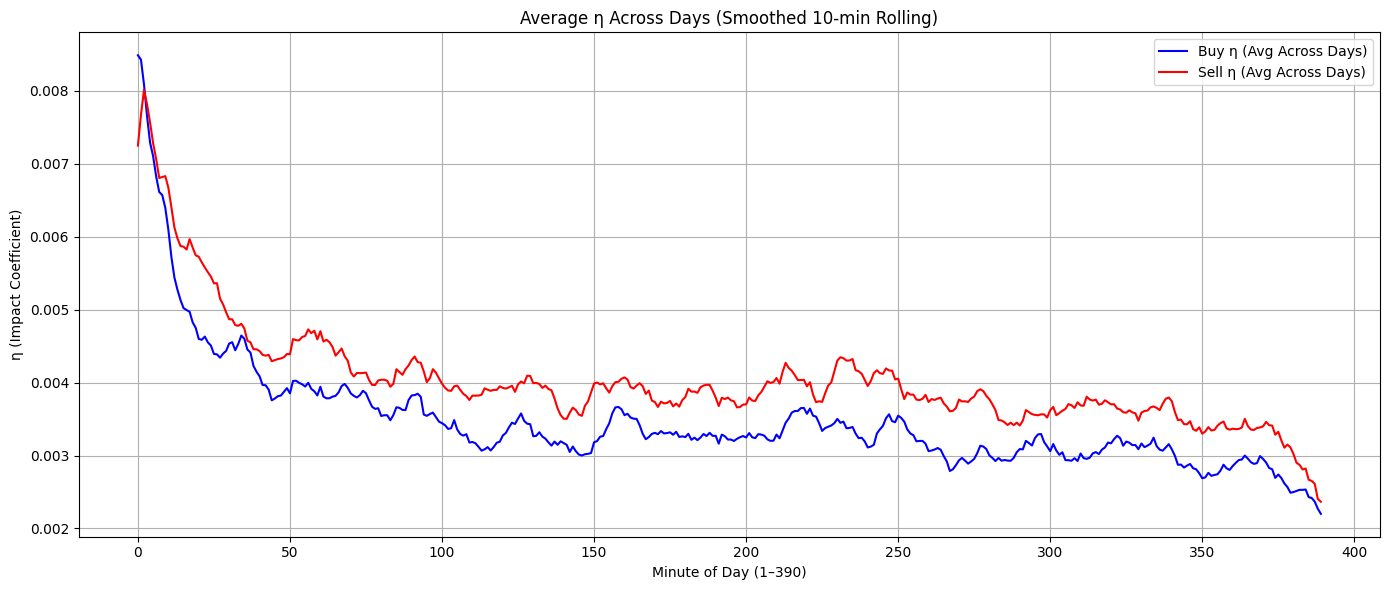

In [14]:
intraday_avg = stack_eta_across_days(all_days_df, window=10)


In [15]:
all_results_Frog = []

files = os.listdir()
crwv = [n for n in files if n.startswith("FROG")]
for date_file in crwv:

    df = pd.read_csv(date_file)
    df['ts_event'] = pd.to_datetime(df['ts_event'], utc=True, format='mixed')
    df['minute'] = df['ts_event'].dt.floor('min')   # round down to the minute
    result = df.groupby('minute').last().reset_index()
    result['Total_ask_book'] = 0
    result['Total_bid_book'] = 0
    for i in range(len(result)):
      sum=0
      sum1=0
      for j in range(10):
        sum+=result.loc[i,f'ask_sz_0{j}']
        sum1+=result.loc[i,f'bid_sz_0{j}']
      result.loc[i,'Total_ask_book'] = sum
      result.loc[i,'Total_bid_book'] = sum1
    # print(result['Total_ask_book'].min())
    # result['idx'] = result.index
    # Estimate η for that day
    day_results = estimate_eta(result,result['Total_ask_book'].min(), result['Total_bid_book'].min(), alpha_fixed=0.6)

    # Extract date from filename
    trade_date = date_file.split(".")[0]   # or parse from filename if needed
    day_results['date'] = trade_date

    all_results_Frog.append(day_results)

# Combine into one DataFrame
all_days_df_frog = pd.concat(all_results_Frog, ignore_index=True)


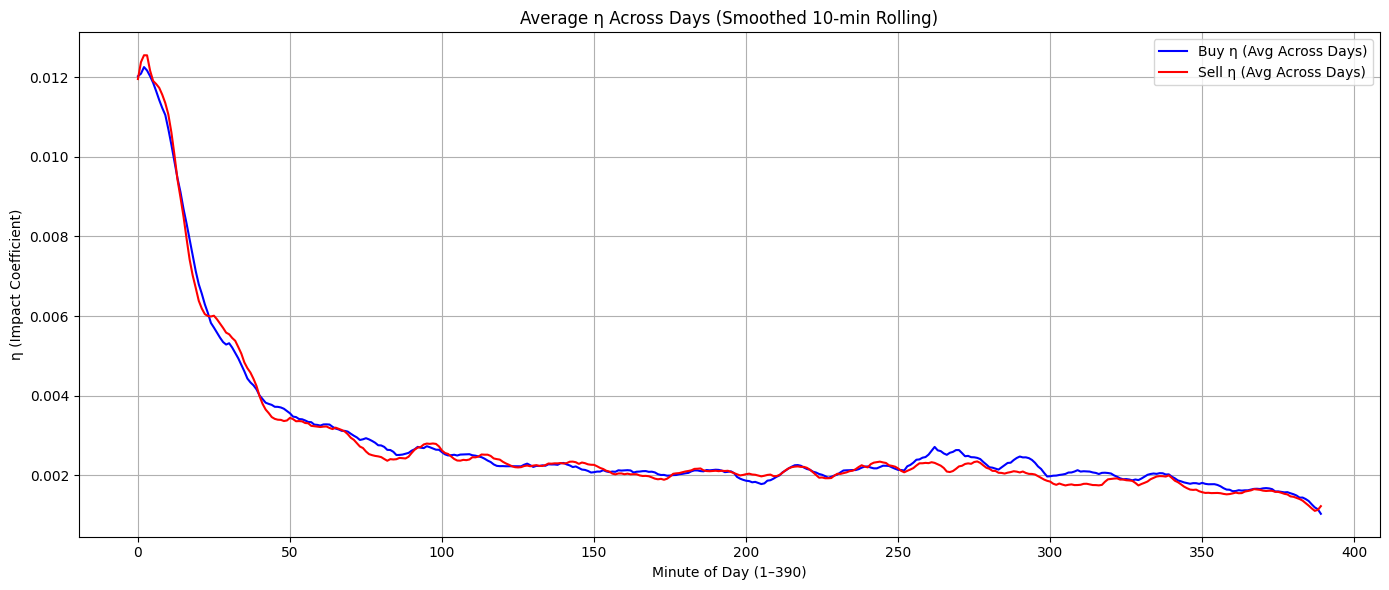

In [16]:
intraday_avg = stack_eta_across_days(all_days_df_frog, window=10)


In [17]:
all_results_soun = []

files = os.listdir()
crwv = [n for n in files if n.startswith("SOUN")]
for date_file in crwv:

    df = pd.read_csv(date_file)
    df['ts_event'] = pd.to_datetime(df['ts_event'], utc=True, format='mixed')
    df['minute'] = df['ts_event'].dt.floor('min')   # round down to the minute
    result = df.groupby('minute').last().reset_index()
    result['Total_ask_book'] = 0
    result['Total_bid_book'] = 0
    for i in range(len(result)):
      sum=0
      sum1=0
      for j in range(10):
        sum+=result.loc[i,f'ask_sz_0{j}']
        sum1+=result.loc[i,f'bid_sz_0{j}']
      result.loc[i,'Total_ask_book'] = sum
      result.loc[i,'Total_bid_book'] = sum1
    # print(result['Total_ask_book'].min())
    # result['idx'] = result.index
    # Estimate η for that day
    day_results = estimate_eta(result,result['Total_ask_book'].min(), result['Total_bid_book'].min(), alpha_fixed=0.6)

    # Extract date from filename
    trade_date = date_file.split(".")[0]   # or parse from filename if needed
    day_results['date'] = trade_date

    all_results_soun.append(day_results)

# Combine into one DataFrame
all_days_df_soun = pd.concat(all_results_soun, ignore_index=True)


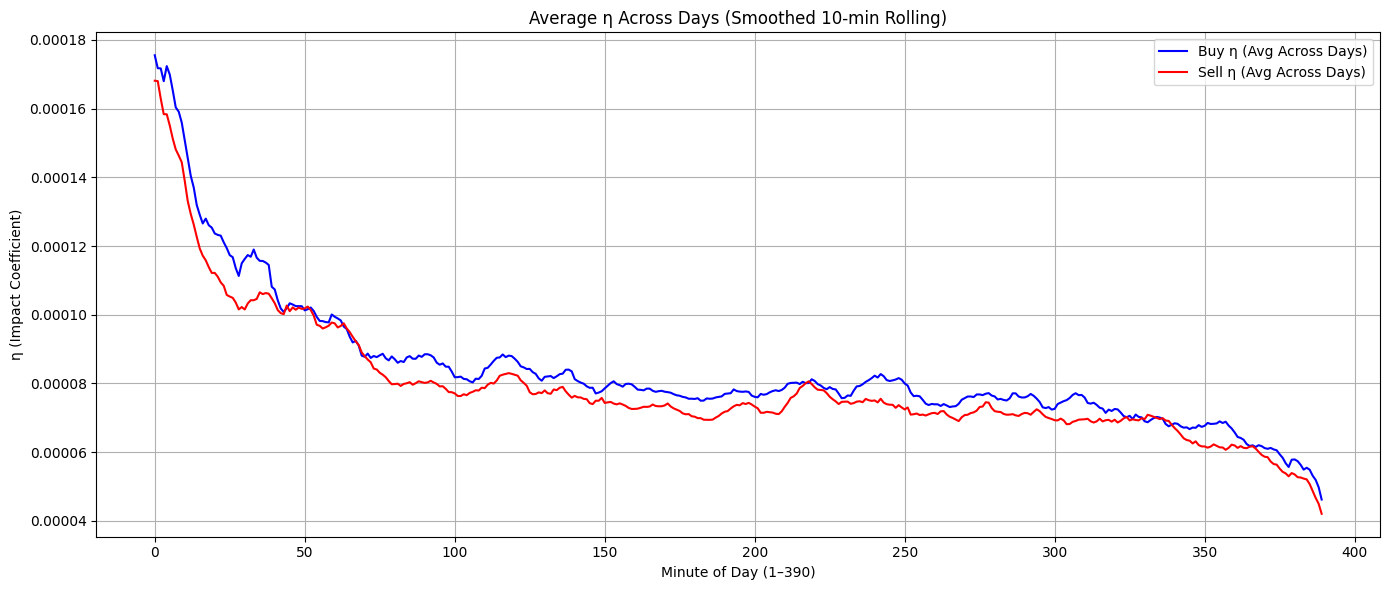

In [18]:
intraday_avg = stack_eta_across_days(all_days_df_soun, window=10)
